# 1.- Load libraries

In [1]:
from influxdb import DataFrameClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import requests 
from datetime import datetime
import time
import ast

# 2.- Prepare Database

We have stored all the data from the different websocket streams in an InfluxDB

In [2]:
client = DataFrameClient('localhost', 8086, 'root', 'root')

In [3]:
client.get_list_database()

[{'name': '_internal'},
 {'name': 'Market'},
 {'name': 'difBook'},
 {'name': 'demo'},
 {'name': 'Markets'}]

In [4]:
client.switch_database("Markets")

In [5]:
client.get_list_measurements()

[{'name': 'Book'}, {'name': 'Price'}, {'name': 'difBook'}]

## 2.1 Read Trades performed
We read the trades performed in the different exchanges under analysis during the test time

In [6]:
points = client.query("SELECT * FROM Price WHERE time > '2020-05-01 17:50:00' and time < '2020-05-02 17:50:00'")

Check times. For future analysis, we have to take the differences into account. Still I dont have figure it out how to make sure that the times reported by the different exchanges are equivalent to each other (i.e that 14:00 in Binance means 14:00 in Huobi for example)

In [7]:
# Time checks
response = requests.get('https://api.kraken.com/0/public/Time')
print("Kraken Time:   " + datetime.fromtimestamp(response.json()["result"]["unixtime"]).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://api.huobi.pro/v1/common/timestamp')
print("Huobi Time:    " + datetime.fromtimestamp(response.json()["data"]/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://api.pro.coinbase.com/time')
print("Coinbase Time: " + response.json()["iso"])
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://www.bitstamp.net/api/ticker/')
print("Bitstamp Time: " + datetime.fromtimestamp(int(response.json()["timestamp"])).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://global-openapi.bithumb.pro/openapi/v1/serverTime')
print("Bithumb Time:  " + datetime.fromtimestamp(response.json()["timestamp"]/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://api.kraken.com/0/public/Time')
print("Kraken Time:   " + datetime.fromtimestamp(response.json()["result"]["unixtime"]).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://api-pub.bitfinex.com/v2/status/deriv?keys=tBTCF0:USTF0')
print("Bitfinex Time: " + str(datetime.fromtimestamp(response.json()[0][1]/1000)))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))
print("------------------------------------------------------------------")

response = requests.get('https://api.binance.com/api/v1/time')
print("Binance Time:  " + datetime.fromtimestamp(response.json()["serverTime"]/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
print("Computer Time: " + str(datetime.fromtimestamp(time.time())))

Kraken Time:   2020-05-05 09:24:38.000000
Computer Time: 2020-05-05 09:24:37.787533
------------------------------------------------------------------
Huobi Time:    2020-05-05 09:24:38.500000
Computer Time: 2020-05-05 09:24:38.274644
------------------------------------------------------------------
Coinbase Time: 2020-05-05T07:24:38.849Z
Computer Time: 2020-05-05 09:24:38.562868
------------------------------------------------------------------
Bitstamp Time: 2020-05-05 09:24:38.000000
Computer Time: 2020-05-05 09:24:38.842659
------------------------------------------------------------------
Bithumb Time:  2020-05-05 09:24:39.587000
Computer Time: 2020-05-05 09:24:39.338286
------------------------------------------------------------------
Kraken Time:   2020-05-05 09:24:39.000000
Computer Time: 2020-05-05 09:24:39.669963
------------------------------------------------------------------
Bitfinex Time: 2020-05-05 09:24:39
Computer Time: 2020-05-05 09:24:39.904072
-------------------

### 2.1.1 Check for duplicates in Trades data
Here we do some checks to confirm that the code used to extract the data is working well

In [8]:
#1.- Check for duplicates
dup_number = np.sum(points["Price"].iloc[:,0:4].reset_index().duplicated())

In [9]:
if dup_number != 0:
    points["Price"][points["Price"].iloc[:,0:4].reset_index().duplicated()]
else:
    print("No duplicates")

No duplicates


### 2.1.1 Check that all exchanges and pairs are in

Here we check the different pairs. Bitflyer has barely no activity, so maybe I will remove it (it mainly works with JPY).

In [10]:
exchanges = np.unique(points["Price"]["Host"])
np.unique(points["Price"]["Host"] + " - " + points["Price"]["Pair"])

array(['Binance - ethbtc', 'BitFlyer - btcusd', 'Bitfinex - btcusd',
       'Bitfinex - ethbtc', 'Bitfinex - ethusd', 'Bitfinex - xtzusd',
       'Bithumb - ethbtc', 'Bitstamp - btcusd', 'Bitstamp - ethbtc',
       'Bitstamp - ethusd', 'Coinbase - btcusd', 'Coinbase - dashusd',
       'Coinbase - ethbtc', 'Coinbase - ethusd', 'Coinbase - xtzusd',
       'Huobi - ethbtc', 'Kraken - ethbtc'], dtype=object)

Some checks I want to do:

- If Kraken data is good (to many repetitive prices, I think it is because the precission is lower for kraken prices than for the rest)
- If Bithumb time reported is good (otherwise we have the first example of arbitrage, although the range is very small)


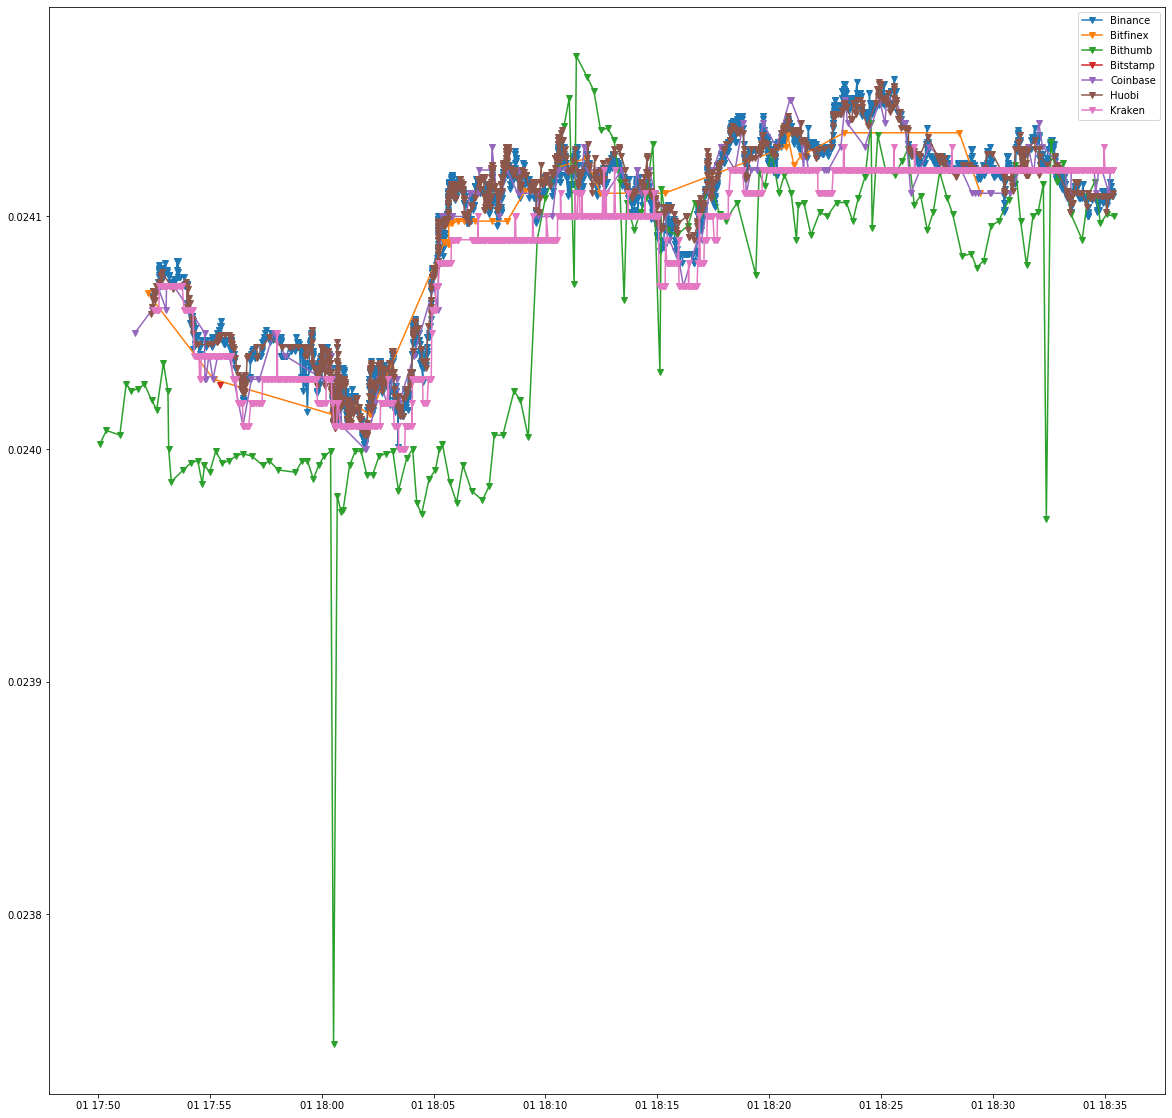

In [12]:
# Print last trades prices 
df = points["Price"][points["Price"]["Pair"] == "ethbtc"]
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,20)
for k,g in df.groupby(['Host'])['Price']:
    ax.plot_date(pd.to_datetime(g.index),g,'v-',label="{}".format(k))
ax.legend()

## 2.1.2- Dataset preparation

I am going to try to prepare a dataset suitable for training for that I will try to create a dataset with one entrance per milisecond.

In [15]:
df2 = df[df["Host"] == exchanges[0]].groupby(pd.Grouper(freq = "ms")).agg({"Price":[np.mean],"Q":[np.sum]}).fillna(method = "ffill")
df2.columns = df2.columns.droplevel(level = 0)
df2 = df2.rename(columns = {"mean": "LastTrade Binance", "sum": "Q Binance"})
for i in exchanges[1::]:
    dft = df[df["Host"] == i].groupby(pd.Grouper(freq = "ms")).agg({"Price":[np.mean],"Q":[np.sum]}).fillna(method = "ffill")
    df2[["LastTrade " + i, "Q "+i]] = dft[["Price", "Q"]]
df2.update(df2[["LastTrade Binance", "LastTrade Bitfinex", "LastTrade Bithumb", 
                "LastTrade Bitstamp", "LastTrade Coinbase", "LastTrade Huobi", 
                "LastTrade Kraken", "LastTrade BitFlyer"]].ffill().bfill())
df2.update(df2[["Q Binance", "Q Bitfinex", "Q Bithumb", 
                "Q Bitstamp", "Q Coinbase", "Q Huobi", "Q Kraken","Q BitFlyer"]].fillna(0))

df2

,LastTrade Binance,Q Binance,LastTrade BitFlyer,Q BitFlyer,LastTrade Bitfinex,Q Bitfinex,LastTrade Bithumb,Q Bithumb,LastTrade Bitstamp,Q Bitstamp,LastTrade Coinbase,Q Coinbase,LastTrade Huobi,Q Huobi,LastTrade Kraken,Q Kraken
2020-05-01 17:52:24.535000+00:00,0.024066,0.141,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0
2020-05-01 17:52:24.536000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0
2020-05-01 17:52:24.537000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0
2020-05-01 17:52:24.538000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0
2020-05-01 17:52:24.539000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01 18:35:22.216000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0
2020-05-01 18:35:22.217000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0
2020-05-01 18:35:22.218000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0
2020-05-01 18:35:22.219000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0


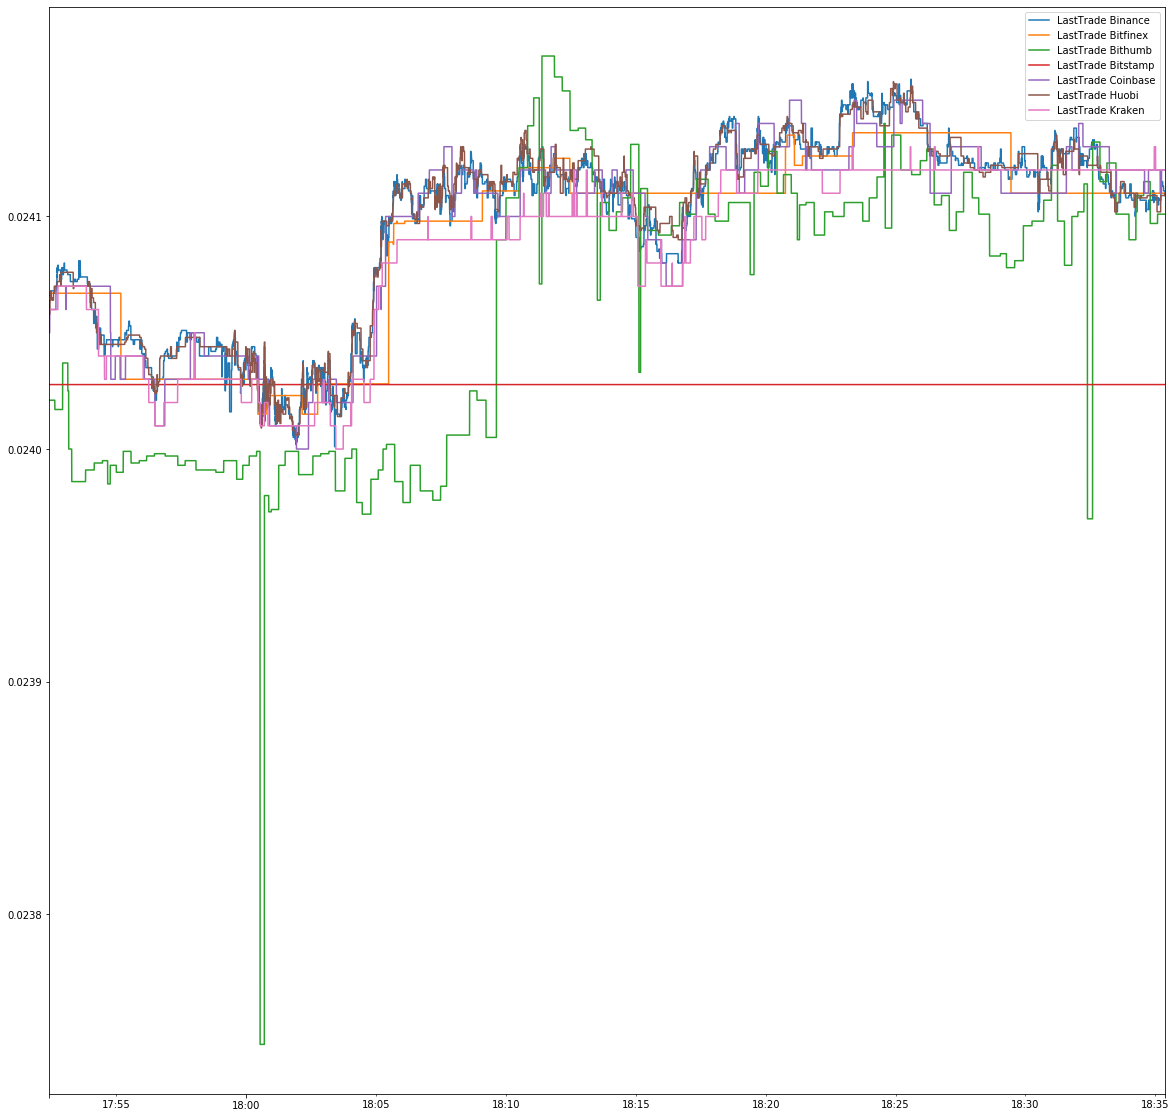

In [18]:
df2[["LastTrade Binance", "LastTrade Bitfinex", "LastTrade Bithumb", 
                "LastTrade Bitstamp", "LastTrade Coinbase", "LastTrade Huobi", "LastTrade Kraken"]].plot()

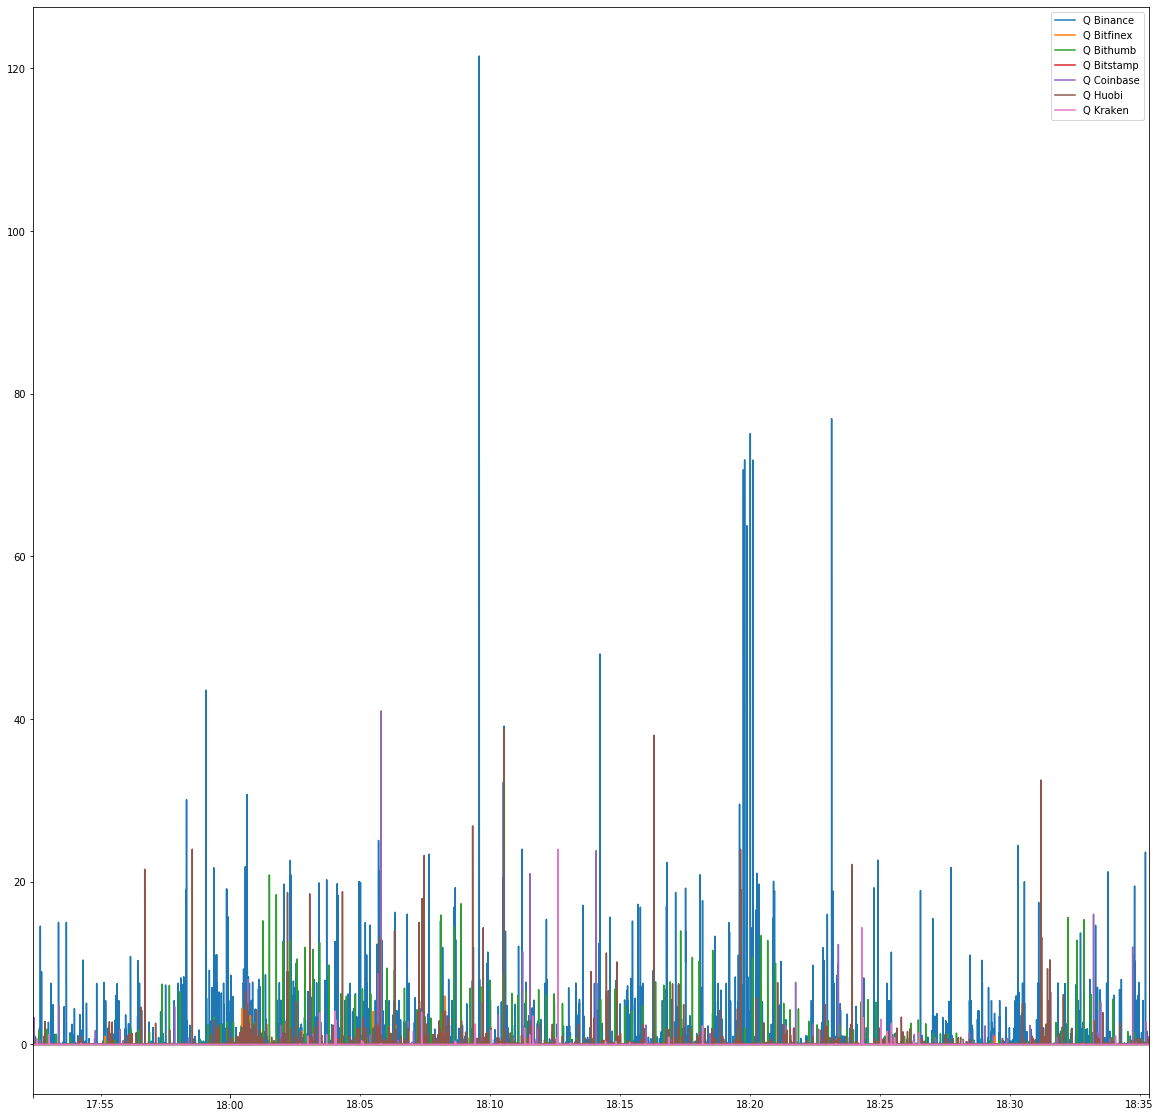

In [19]:
# Volume check
np.abs(df2[["Q Binance", "Q Bitfinex", "Q Bithumb", 
                "Q Bitstamp", "Q Coinbase", "Q Huobi", "Q Kraken"]]).plot()

From here I'm thinking in computing different price differences metrics (Maximum difference over intervals, voulmes...)
Maybe an LSTM using the previous data of last trades to predict 

### 2.1.2.1 Check order books

In [59]:
points_book = client.query("SELECT * FROM Book WHERE time > '2020-05-01 17:50:00' and time < '2020-05-01 17:50:00'")
points_book["Book"]

KeyError: 'Book'

In [17]:
points_dif = client.query("SELECT * FROM difBook WHERE time > '2020-05-01 17:50:00'")
points_dif["difBook"]

,Asks,Bids,Host,Pair,Seg
2020-05-01 17:52:22.012999936+00:00,-13.16004912,210.53,Bitfinex,ethusd,44474557028
2020-05-01 17:52:22.113999872+00:00,-1,0,Bitfinex,ethusd,44476781227
2020-05-01 17:52:22.128999936+00:00,1,0,Bitfinex,xtzusd,44476787631
2020-05-01 17:52:22.167000064+00:00,500,2.68,Bitfinex,xtzusd,44405183527
2020-05-01 17:52:22.200000+00:00,-1,0,Bitfinex,ethusd,44476781231
...,...,...,...,...,...
2020-05-01 18:35:21.433999872+00:00,"[['209.92', '0.00000000'], ['209.99', '0.00000...","[['209.61', '0.00000000'], ['209.07', '3.39500...",Bitstamp,ethusd,['1588350921788225']
2020-05-01 18:35:21.440000+00:00,[],"[{'price': 0.02344, 'size': 0.0}]",BitFlyer,ethbtc,-
2020-05-01 18:35:21.552000+00:00,[],"[{'price': 8675.29, 'size': 0.09193922}]",BitFlyer,btcusd,-
2020-05-01 18:35:22.176999936+00:00,"[['0.02410900', '0.00800000'], ['0.02411000', ...","[['0.02410600', '0.00000000'], ['0.02410500', ...",Binance,ethbtc,"[1184246862, 1184246841]"


### 2.1.2.1 Check unique elements and duplicates

In [18]:
np.unique(points_book["Book"]["Host"])

array(['Binance', 'BitFlyer', 'Bitfinex', 'Bithumb', 'Bitstamp',
       'Coinbase', 'Huobi', 'Kraken'], dtype=object)

In [19]:
np.unique(points_dif["difBook"]["Host"])
# Huobi is not here because we are gathering the order book by second in the previous table.
# It was way too messy to try to gather the differential order book. I will do it if I have spare time only.

array(['Binance', 'BitFlyer', 'Bitfinex', 'Bithumb', 'Bitstamp',
       'Coinbase', 'Kraken'], dtype=object)

In [20]:
#Check for duplicates
dup_number = np.sum(points_book["Book"].reset_index().duplicated())
if dup_number != 0:
    points["Book"][points_book["Book"].reset_index().duplicated()]
else:
    print("No duplicates")

No duplicates


In [21]:
dup_number = np.sum(points_dif["difBook"].reset_index().duplicated())

if dup_number != 0:
    points_dif["difBook"][points_dif["difBook"].reset_index().duplicated()]
else:
    print("No duplicates")

No duplicates


### 2.1.2.2. Reconstructing Binance OrderBook

In [22]:
# First snapshots
dfT = points_book["Book"]
d = dfT[dfT["Host"] == "Binance"]
d

,Asks,Bids,Host,LastUpdateID,Pair
2020-05-01 17:52:26.372000+00:00,"[['0.02406900', '0.02500000'], ['0.02407000', ...","[['0.02406600', '26.08000000'], ['0.02406500',...",Binance,1184152253,ethbtc
2020-05-01 17:52:38.049999872+00:00,"[['0.02406900', '0.05000000'], ['0.02407000', ...","[['0.02406800', '136.75600000'], ['0.02406700'...",Binance,1184152463,ethbtc
2020-05-01 17:52:50.433999872+00:00,"[['0.02407900', '0.04400000'], ['0.02408000', ...","[['0.02407600', '23.71100000'], ['0.02407400',...",Binance,1184152716,ethbtc
2020-05-01 17:53:02.367000064+00:00,"[['0.02408100', '2.48800000'], ['0.02408200', ...","[['0.02407700', '22.61800000'], ['0.02407600',...",Binance,1184153013,ethbtc
2020-05-01 17:53:14.625999872+00:00,"[['0.02407600', '2.47900000'], ['0.02407700', ...","[['0.02407200', '22.78500000'], ['0.02407100',...",Binance,1184153359,ethbtc
2020-05-01 17:53:27.091000064+00:00,"[['0.02407500', '0.00800000'], ['0.02407800', ...","[['0.02407300', '27.06000000'], ['0.02407200',...",Binance,1184153713,ethbtc


In [23]:
# First updates
dfT_dif = points_dif["difBook"]
d_dif = dfT_dif[dfT_dif["Host"] == "Binance"]
d_dif

,Asks,Bids,Host,Pair,Seg
2020-05-01 17:52:24.136999936+00:00,"[['0.02406900', '53.02500000'], ['0.02407000',...","[['0.02406600', '24.00000000'], ['0.02406500',...",Binance,ethbtc,"[1184152200, 1184152168]"
2020-05-01 17:52:25.136999936+00:00,"[['0.02406900', '0.02500000'], ['0.02407200', ...","[['0.02406600', '23.74400000'], ['0.02405200',...",Binance,ethbtc,"[1184152225, 1184152201]"
2020-05-01 17:52:26.136999936+00:00,"[['0.02407600', '2.50600000'], ['0.02407900', ...","[['0.02406600', '26.08000000'], ['0.02406500',...",Binance,ethbtc,"[1184152245, 1184152226]"
2020-05-01 17:52:27.136999936+00:00,"[['0.02407200', '2.95400000'], ['0.02409000', ...","[['0.02405800', '8.30900000'], ['0.02405600', ...",Binance,ethbtc,"[1184152257, 1184152246]"
2020-05-01 17:52:28.136999936+00:00,"[['0.02407200', '0.09100000'], ['0.02407400', ...","[['0.02406800', '24.00000000'], ['0.02406700',...",Binance,ethbtc,"[1184152282, 1184152258]"
...,...,...,...,...,...
2020-05-01 18:35:18.176999936+00:00,"[['0.02411200', '130.57400000'], ['0.02411300'...","[['0.02410100', '20.69100000'], ['0.02409100',...",Binance,ethbtc,"[1184246770, 1184246741]"
2020-05-01 18:35:19.176999936+00:00,"[['0.02411100', '0.00800000'], ['0.02411200', ...","[['0.02411100', '0.00000000'], ['0.02410800', ...",Binance,ethbtc,"[1184246812, 1184246771]"
2020-05-01 18:35:20.176999936+00:00,"[['0.02411200', '130.13000000'], ['0.02412100'...","[['0.02410600', '4.24600000'], ['0.02409900', ...",Binance,ethbtc,"[1184246823, 1184246813]"
2020-05-01 18:35:21.176999936+00:00,"[['0.02411100', '4.19400000'], ['0.02411200', ...","[['0.02410400', '0.00000000'], ['0.02409800', ...",Binance,ethbtc,"[1184246840, 1184246824]"


### 2.1.2.3 Ploting order book snapshot

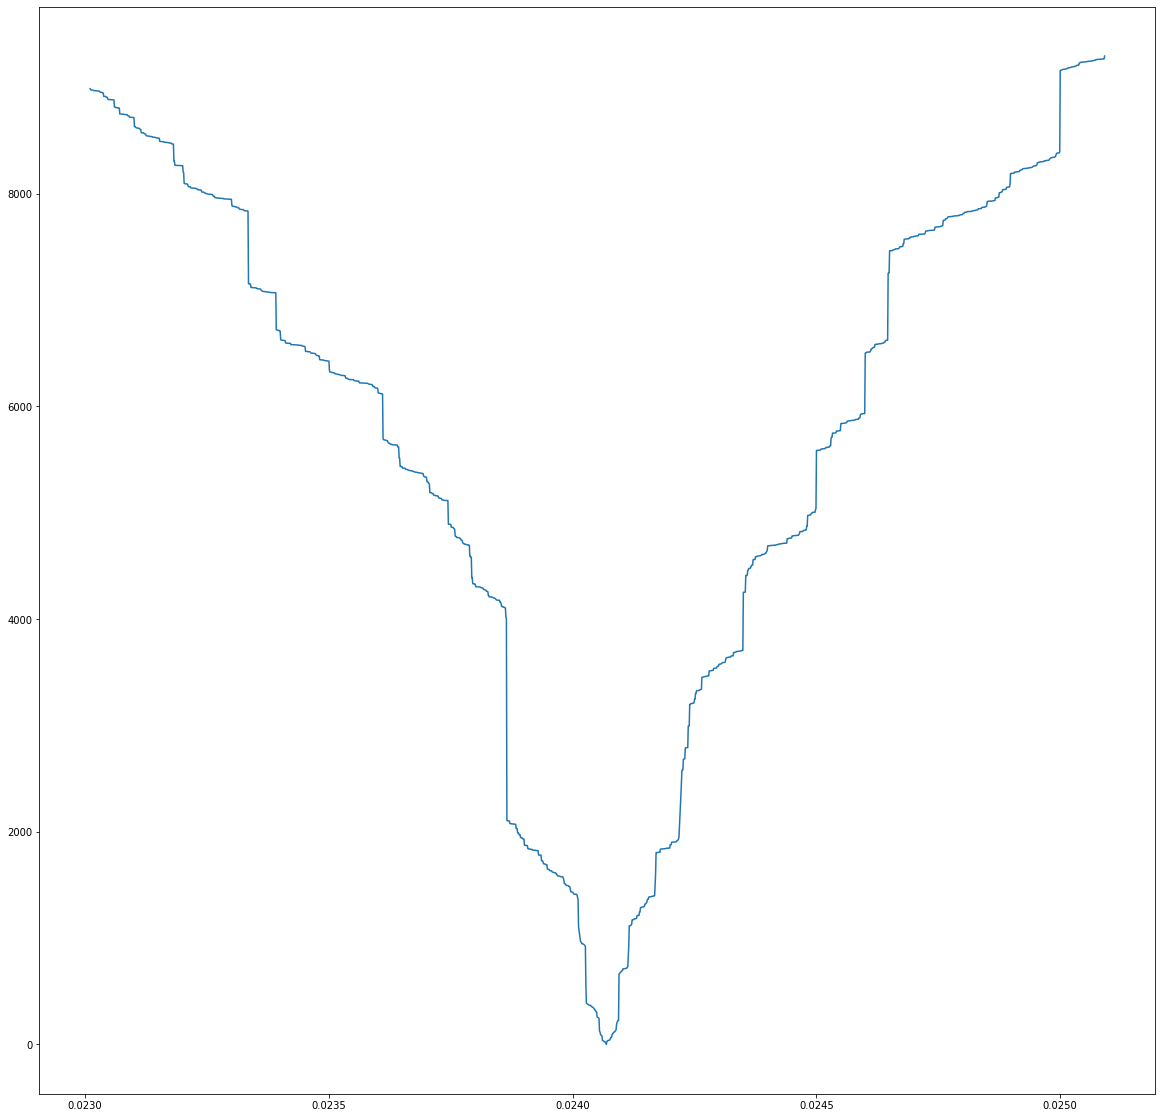

In [24]:
bids = d.iloc[:,0].apply(lambda x: [[float(j) for j in i] for i in ast.literal_eval(x)])[0]
asks = d.iloc[:,1].apply(lambda x: [[float(j) for j in i] for i in ast.literal_eval(x)])[0]
# print(bids)
# print("ASKS")
# print(asks)
price_b = [bids[i][0] for i in range(len(bids))]
price_a = [asks[-(i+1)][0] for i in range(len(asks))]
# print("PRICESS")
# print(price_b)
price = price_a + price_b

freq_b = np.cumsum([bids[i][1] for i in range(len(bids))]).tolist()
freq_a = np.cumsum([asks[i][1] for i in range(len(asks))])[::-1].tolist()

freq = freq_a + freq_b
plt.plot(price,freq)

In [25]:
# Pass numbers to float format
d_dif.loc[:,"Seg"] = d_dif.loc[:,"Seg"].apply(lambda x: ast.literal_eval(x))
d.loc[:, "Asks"] = d.loc[:,"Asks"].apply(lambda x: dict(list([[i[0],float(i[1])] for i in ast.literal_eval(x)])))
d.loc[:,"Bids"] = d.loc[:,"Bids"].apply(lambda x: dict(list([[i[0],float(i[1])] for i in ast.literal_eval(x)])))
d_dif.loc[:, "Asks"] = d_dif.loc[:,"Asks"].apply(lambda x: dict(list([[i[0],float(i[1])] for i in ast.literal_eval(x)])))
d_dif.loc[:,"Bids"] = d_dif.loc[:,"Bids"].apply(lambda x: dict(list([[i[0],float(i[1])] for i in ast.literal_eval(x)])))

d_dif

C:\Users\Daniel\anaconda3\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Asks,Bids,Host,Pair,Seg
2020-05-01 17:52:24.136999936+00:00,"{'0.02406900': 53.025, '0.02407000': 24.609, '...","{'0.02406600': 24.0, '0.02406500': 0.008, '0.0...",Binance,ethbtc,"[1184152200, 1184152168]"
2020-05-01 17:52:25.136999936+00:00,"{'0.02406900': 0.025, '0.02407200': 0.091, '0....","{'0.02406600': 23.744, '0.02405200': 0.0, '0.0...",Binance,ethbtc,"[1184152225, 1184152201]"
2020-05-01 17:52:26.136999936+00:00,"{'0.02407600': 2.506, '0.02407900': 0.066, '0....","{'0.02406600': 26.08, '0.02406500': 0.008, '0....",Binance,ethbtc,"[1184152245, 1184152226]"
2020-05-01 17:52:27.136999936+00:00,"{'0.02407200': 2.954, '0.02409000': 46.738, '0...","{'0.02405800': 8.309, '0.02405600': 23.149, '0...",Binance,ethbtc,"[1184152257, 1184152246]"
2020-05-01 17:52:28.136999936+00:00,"{'0.02407200': 0.091, '0.02407400': 2.855, '0....","{'0.02406800': 24.0, '0.02406700': 12.699, '0....",Binance,ethbtc,"[1184152282, 1184152258]"
...,...,...,...,...,...
2020-05-01 18:35:18.176999936+00:00,"{'0.02411200': 130.574, '0.02411300': 22.401, ...","{'0.02410100': 20.691, '0.02409100': 0.0, '0.0...",Binance,ethbtc,"[1184246770, 1184246741]"
2020-05-01 18:35:19.176999936+00:00,"{'0.02411100': 0.008, '0.02411200': 125.884, '...","{'0.02411100': 0.0, '0.02410800': 0.0, '0.0241...",Binance,ethbtc,"[1184246812, 1184246771]"
2020-05-01 18:35:20.176999936+00:00,"{'0.02411200': 130.13, '0.02412100': 14.006, '...","{'0.02410600': 4.246, '0.02409900': 1.721, '0....",Binance,ethbtc,"[1184246823, 1184246813]"
2020-05-01 18:35:21.176999936+00:00,"{'0.02411100': 4.194, '0.02411200': 125.884, '...","{'0.02410400': 0.0, '0.02409800': 0.0, '0.0240...",Binance,ethbtc,"[1184246840, 1184246824]"


In [26]:
# Check that we haven't miss any message from the websocket. If numbers differ some message is missing
jumps = np.asarray([d_dif["Seg"][i][0]+1 == d_dif["Seg"].shift(-1)[i][1] for i in range(0,len(d_dif)-1)])
jumps2 = np.asarray([[d_dif["Seg"][i][0]+1, d_dif["Seg"].shift(-1)[i][1]] for i in range(0,len(d_dif)-1)])
print(np.sum([d_dif["Seg"][i][0]+1 == d_dif["Seg"].shift(-1)[i][1] for i in range(0,len(d_dif)-1)]))
print(len(jumps))

2578
2578


The idea would be to add to the dataframe of the previous part metrics from each order book in order to train the model

In [27]:
# Gather first snapshot valid
d["Type"] = "Snapshot"
d_dif["Type"] = "Dif"
first = 0
for i in range(len(d)):
    for j in range(len(d_dif)):
        if d_dif.iloc[j,4][1] < int(d.iloc[i,3]) and d_dif.iloc[j,4][0] > int(d.iloc[i,3]):
            first = [i,j]
            break
        elif d_dif.iloc[j,4][1] > int(d.iloc[i,3]):
            break
    if first != 0:
        break

C:\Users\Daniel\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Daniel\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
d_join = d_dif.iloc[first[1]::,[0,1,4,5]].rename(columns = {"Seg":"LastUpdateID"}).append(d[["Asks","Bids","LastUpdateID", "Type"]].iloc[first[0],:]).sort_index()
d_join

,Asks,Bids,LastUpdateID,Type
2020-05-01 17:52:26.372000+00:00,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 26.08, '0.02406500': 0.008, '0....",1184152253,Snapshot
2020-05-01 17:52:27.136999936+00:00,"{'0.02407200': 2.954, '0.02409000': 46.738, '0...","{'0.02405800': 8.309, '0.02405600': 23.149, '0...","[1184152257, 1184152246]",Dif
2020-05-01 17:52:28.136999936+00:00,"{'0.02407200': 0.091, '0.02407400': 2.855, '0....","{'0.02406800': 24.0, '0.02406700': 12.699, '0....","[1184152282, 1184152258]",Dif
2020-05-01 17:52:29.136999936+00:00,"{'0.02407100': 0.0, '0.02407400': 0.0, '0.0240...","{'0.02406800': 22.784, '0.02406700': 12.881, '...","[1184152308, 1184152283]",Dif
2020-05-01 17:52:30.136999936+00:00,"{'0.02407700': 2.476, '0.02408100': 16.342, '0...","{'0.02406800': 29.678, '0.02406700': 3.018, '0...","[1184152326, 1184152309]",Dif
...,...,...,...,...
2020-05-01 18:35:18.176999936+00:00,"{'0.02411200': 130.574, '0.02411300': 22.401, ...","{'0.02410100': 20.691, '0.02409100': 0.0, '0.0...","[1184246770, 1184246741]",Dif
2020-05-01 18:35:19.176999936+00:00,"{'0.02411100': 0.008, '0.02411200': 125.884, '...","{'0.02411100': 0.0, '0.02410800': 0.0, '0.0241...","[1184246812, 1184246771]",Dif
2020-05-01 18:35:20.176999936+00:00,"{'0.02411200': 130.13, '0.02412100': 14.006, '...","{'0.02410600': 4.246, '0.02409900': 1.721, '0....","[1184246823, 1184246813]",Dif
2020-05-01 18:35:21.176999936+00:00,"{'0.02411100': 4.194, '0.02411200': 125.884, '...","{'0.02410400': 0.0, '0.02409800': 0.0, '0.0240...","[1184246840, 1184246824]",Dif


In [29]:
# Rebuild order book for each timestemp we have
d_join["U_Asks"] = ""
d_join["U_Bids"] = ""
d_join.iat[0,4] = d_join.iloc[0,0].copy()
d_join.iat[0,5] = d_join.iloc[0,1].copy()
for i in range(1,len(d_join)):
    for j in range(2):
        d_join.iat[i,4+j] = d_join.iloc[i-1,4+j].copy()
        for key in d_join.iloc[i,j].keys():
            if  key in d_join.iloc[i,4+j]:
                if d_join.iloc[i,j][key] == 0.0:
                    del d_join.iloc[i,4+j][key]
                else:
                    d_join.iat[i,4+j][key] = d_join.iloc[i,j][key]
            else:
                d_join.iat[i,4+j][key] = d_join.iloc[i,j][key]

d_join

,Asks,Bids,LastUpdateID,Type,U_Asks,U_Bids
2020-05-01 17:52:26.372000+00:00,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 26.08, '0.02406500': 0.008, '0....",1184152253,Snapshot,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 26.08, '0.02406500': 0.008, '0...."
2020-05-01 17:52:27.136999936+00:00,"{'0.02407200': 2.954, '0.02409000': 46.738, '0...","{'0.02405800': 8.309, '0.02405600': 23.149, '0...","[1184152257, 1184152246]",Dif,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 26.08, '0.02406500': 0.008, '0...."
2020-05-01 17:52:28.136999936+00:00,"{'0.02407200': 0.091, '0.02407400': 2.855, '0....","{'0.02406800': 24.0, '0.02406700': 12.699, '0....","[1184152282, 1184152258]",Dif,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 23.164, '0.02406500': 0.008, '0..."
2020-05-01 17:52:29.136999936+00:00,"{'0.02407100': 0.0, '0.02407400': 0.0, '0.0240...","{'0.02406800': 22.784, '0.02406700': 12.881, '...","[1184152308, 1184152283]",Dif,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 23.164, '0.02406500': 0.008, '0..."
2020-05-01 17:52:30.136999936+00:00,"{'0.02407700': 2.476, '0.02408100': 16.342, '0...","{'0.02406800': 29.678, '0.02406700': 3.018, '0...","[1184152326, 1184152309]",Dif,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 23.164, '0.02406500': 0.008, '0..."
...,...,...,...,...,...,...
2020-05-01 18:35:18.176999936+00:00,"{'0.02411200': 130.574, '0.02411300': 22.401, ...","{'0.02410100': 20.691, '0.02409100': 0.0, '0.0...","[1184246770, 1184246741]",Dif,"{'0.02415900': 0.661, '0.02416000': 98.765, '0...","{'0.02400100': 31.616, '0.02399900': 0.15, '0...."
2020-05-01 18:35:19.176999936+00:00,"{'0.02411100': 0.008, '0.02411200': 125.884, '...","{'0.02411100': 0.0, '0.02410800': 0.0, '0.0241...","[1184246812, 1184246771]",Dif,"{'0.02415900': 0.661, '0.02416000': 98.765, '0...","{'0.02400100': 31.616, '0.02399900': 0.15, '0...."
2020-05-01 18:35:20.176999936+00:00,"{'0.02411200': 130.13, '0.02412100': 14.006, '...","{'0.02410600': 4.246, '0.02409900': 1.721, '0....","[1184246823, 1184246813]",Dif,"{'0.02415900': 0.661, '0.02416000': 98.765, '0...","{'0.02400100': 31.616, '0.02399900': 0.15, '0...."
2020-05-01 18:35:21.176999936+00:00,"{'0.02411100': 4.194, '0.02411200': 125.884, '...","{'0.02410400': 0.0, '0.02409800': 0.0, '0.0240...","[1184246840, 1184246824]",Dif,"{'0.02415900': 0.661, '0.02416000': 98.765, '0...","{'0.02400100': 31.616, '0.02399900': 0.15, '0...."


In [30]:
# Compute orderbook price to add to the main dataset
first = 0
second = 0
d_join["OrderBookPrice"] = ""
for i in range(len(d_join)):
    values = sorted(d_join.iloc[i,4].keys())
    values2 = sorted(d_join.iloc[i,5].keys(), reverse = True)
    for j in values:
        if d_join.iloc[i,4][j] > 0:
            first = float(j)
            break
    for j in values2:
        if d_join.iloc[i,5][j] > 0:
            second = float(j)
            break
    d_join.iat[i,6] = (first + second) / 2
    
d_join

,Asks,Bids,LastUpdateID,Type,U_Asks,U_Bids,OrderBookPrice
2020-05-01 17:52:26.372000+00:00,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 26.08, '0.02406500': 0.008, '0....",1184152253,Snapshot,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 26.08, '0.02406500': 0.008, '0....",0.0240675
2020-05-01 17:52:27.136999936+00:00,"{'0.02407200': 2.954, '0.02409000': 46.738, '0...","{'0.02405800': 8.309, '0.02405600': 23.149, '0...","[1184152257, 1184152246]",Dif,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 26.08, '0.02406500': 0.008, '0....",0.0240675
2020-05-01 17:52:28.136999936+00:00,"{'0.02407200': 0.091, '0.02407400': 2.855, '0....","{'0.02406800': 24.0, '0.02406700': 12.699, '0....","[1184152282, 1184152258]",Dif,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 23.164, '0.02406500': 0.008, '0...",0.0240685
2020-05-01 17:52:29.136999936+00:00,"{'0.02407100': 0.0, '0.02407400': 0.0, '0.0240...","{'0.02406800': 22.784, '0.02406700': 12.881, '...","[1184152308, 1184152283]",Dif,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 23.164, '0.02406500': 0.008, '0...",0.0240685
2020-05-01 17:52:30.136999936+00:00,"{'0.02407700': 2.476, '0.02408100': 16.342, '0...","{'0.02406800': 29.678, '0.02406700': 3.018, '0...","[1184152326, 1184152309]",Dif,"{'0.02406900': 0.025, '0.02407000': 24.609, '0...","{'0.02406600': 23.164, '0.02406500': 0.008, '0...",0.0240685
...,...,...,...,...,...,...,...
2020-05-01 18:35:18.176999936+00:00,"{'0.02411200': 130.574, '0.02411300': 22.401, ...","{'0.02410100': 20.691, '0.02409100': 0.0, '0.0...","[1184246770, 1184246741]",Dif,"{'0.02415900': 0.661, '0.02416000': 98.765, '0...","{'0.02400100': 31.616, '0.02399900': 0.15, '0....",0.0241115
2020-05-01 18:35:19.176999936+00:00,"{'0.02411100': 0.008, '0.02411200': 125.884, '...","{'0.02411100': 0.0, '0.02410800': 0.0, '0.0241...","[1184246812, 1184246771]",Dif,"{'0.02415900': 0.661, '0.02416000': 98.765, '0...","{'0.02400100': 31.616, '0.02399900': 0.15, '0....",0.024108
2020-05-01 18:35:20.176999936+00:00,"{'0.02411200': 130.13, '0.02412100': 14.006, '...","{'0.02410600': 4.246, '0.02409900': 1.721, '0....","[1184246823, 1184246813]",Dif,"{'0.02415900': 0.661, '0.02416000': 98.765, '0...","{'0.02400100': 31.616, '0.02399900': 0.15, '0....",0.0241085
2020-05-01 18:35:21.176999936+00:00,"{'0.02411100': 4.194, '0.02411200': 125.884, '...","{'0.02410400': 0.0, '0.02409800': 0.0, '0.0240...","[1184246840, 1184246824]",Dif,"{'0.02415900': 0.661, '0.02416000': 98.765, '0...","{'0.02400100': 31.616, '0.02399900': 0.15, '0....",0.0241085


### 2.1.2.4 Join OrderBook metrics with trades

In [31]:
df2

,Price Binance,Q Binance,Price BitFlyer,Q BitFlyer,Price Bitfinex,Q Bitfinex,Price Bithumb,Q Bithumb,Price Bitstamp,Q Bitstamp,Price Coinbase,Q Coinbase,Price Huobi,Q Huobi,Price Kraken,Q Kraken
2020-05-01 17:52:24.535000+00:00,0.024066,0.141,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0
2020-05-01 17:52:24.536000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0
2020-05-01 17:52:24.537000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0
2020-05-01 17:52:24.538000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0
2020-05-01 17:52:24.539000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01 18:35:22.216000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0
2020-05-01 18:35:22.217000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0
2020-05-01 18:35:22.218000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0
2020-05-01 18:35:22.219000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0


In [32]:
df2 = pd.merge(df2,d_join["OrderBookPrice"], how='outer', left_index=True, right_index=True)
df2.update(df2[["Price Binance", "Price Bitfinex", "Price Bithumb", 
                "Price Bitstamp", "Price Coinbase", "Price Huobi", "Price Kraken","OrderBookPrice"]].ffill().bfill())
df2.update(df2[["Q Binance", "Q Bitfinex", "Q Bithumb", 
                "Q Bitstamp", "Q Coinbase", "Q Huobi", "Q Kraken"]].fillna(0))
df2

,Price Binance,Q Binance,Price BitFlyer,Q BitFlyer,Price Bitfinex,Q Bitfinex,Price Bithumb,Q Bithumb,Price Bitstamp,Q Bitstamp,Price Coinbase,Q Coinbase,Price Huobi,Q Huobi,Price Kraken,Q Kraken,OrderBookPrice
2020-05-01 17:52:24.535000+00:00,0.024066,0.141,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0,0.0240675
2020-05-01 17:52:24.536000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0,0.0240675
2020-05-01 17:52:24.537000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0,0.0240675
2020-05-01 17:52:24.538000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0,0.0240675
2020-05-01 17:52:24.539000+00:00,0.024066,0.000,NaN,0.0,0.024067,0.0,0.024021,0.0,0.024028,0.0,0.02405,0.0,0.024058,0.0,0.02406,0.0,0.0240675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01 18:35:22.216000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0,0.024107
2020-05-01 18:35:22.217000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0,0.024107
2020-05-01 18:35:22.218000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0,0.024107
2020-05-01 18:35:22.219000+00:00,0.024111,0.000,NaN,0.0,0.024110,0.0,0.024101,0.0,0.024028,0.0,0.02412,0.0,0.024110,0.0,0.02412,0.0,0.024107


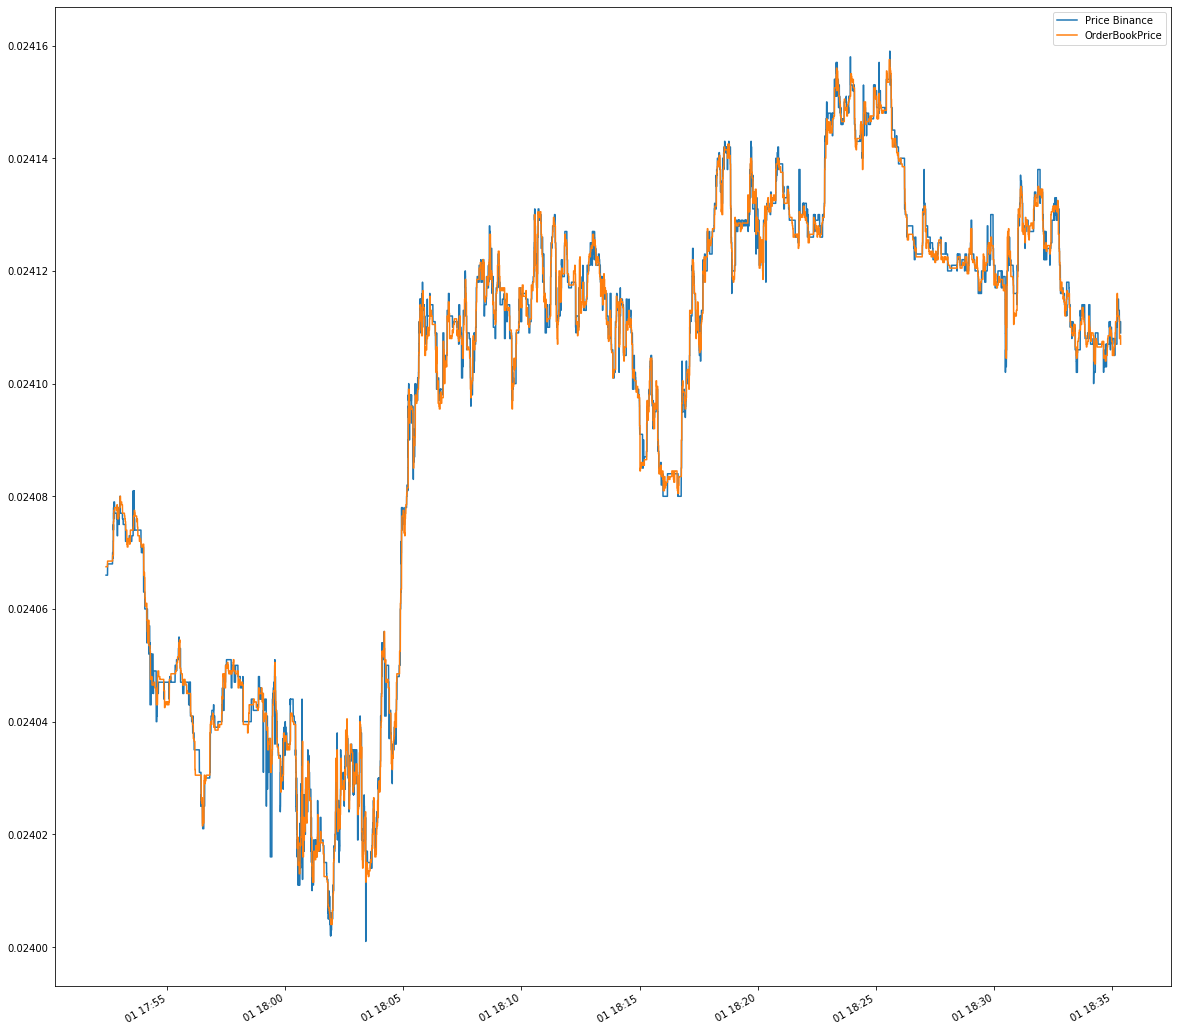

In [33]:
df2[["Price Binance", "OrderBookPrice"]].plot()

# Statistical Tests

In [ ]:
# TBD

# Model

In [ ]:
# TBD